# ML classification model for drone vs nondrone

In [15]:
import os
import numpy as np
from tqdm import tqdm

from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow.keras import layers


In [26]:
DRONE_DIR = "../../data/drone classification data/drone_dataset_npz"
NONDRONE_DIR = "../../data/drone classification data/nondrone_dataset_npz"

BATCH_SIZE = 64
EPOCHS = 5
LR = 1e-3
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

print("Device:", DEVICE)

Device: cpu


In [16]:
def load_folder(folder, label):
    X, y = [], []
    files = [f for f in os.listdir(folder) if f.endswith(".npz")]
    for f in tqdm(files, desc=f"Loading {folder}"):
        z = np.load(os.path.join(folder, f), allow_pickle=True)
        X.append(z["x"].astype(np.float32))
        y.append(label)
    return np.array(X), np.array(y, dtype=np.float32)

X_drone, y_drone = load_folder(DRONE_DIR, 1)
X_non,   y_non   = load_folder(NONDRONE_DIR, 0)

X = np.concatenate([X_drone, X_non], axis=0)
y = np.concatenate([y_drone, y_non], axis=0)

print("Total:", len(X), "Drone:", int(y.sum()), "Non-drone:", int(len(y)-y.sum()))
print("Spectrogram shape:", X[0].shape)


Loading ../../data/drone classification data/drone_dataset_npz: 100%|██████████| 11672/11672 [00:16<00:00, 687.13it/s]
Loading ../../data/drone classification data/nondrone_dataset_npz: 100%|██████████| 12552/12552 [00:17<00:00, 719.56it/s]


Total: 24224 Drone: 11672 Non-drone: 12552
Spectrogram shape: (512, 17)


In [17]:
X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, random_state=0, stratify=y
)

mean = X_train.mean()
std  = X_train.std() + 1e-6

X_train = (X_train - mean) / std
X_val   = (X_val - mean) / std


In [18]:
X_train = X_train[..., None]
X_val   = X_val[..., None]


In [22]:
def add_noise(spec, snr_db):
    signal_power = np.mean(spec**2) + 1e-12
    snr_linear = 10 ** (snr_db / 10)
    noise_power = signal_power / snr_linear

    noise = np.random.normal(
        0.0,
        np.sqrt(noise_power),
        size=spec.shape
    ).astype(np.float32)

    return spec + noise


def augment_with_noise(X, y, prob=0.5, snr_min=-15, snr_max=10):
    X_aug = X.copy()

    for i in range(len(X_aug)):
        if np.random.rand() < prob:
            snr = np.random.uniform(snr_min, snr_max)
            X_aug[i] = add_noise(X_aug[i], snr)

    return X_aug, y


In [39]:
X_train_noisy, y_train_noisy = augment_with_noise(
    X_train,
    y_train,
    prob=0.9,
    snr_min=-20,
    snr_max=0
)


In [41]:
model = tf.keras.Sequential([
    layers.Input(shape=X_train.shape[1:]),

    layers.Conv2D(32, 3, strides=2, padding="same", activation="relu"),
    layers.Conv2D(32, 3, padding="same", activation="relu"),
    layers.Dropout(0.2),

    layers.Conv2D(64, 3, strides=2, padding="same", activation="relu"),
    layers.Conv2D(64, 3, padding="same", activation="relu"),
    layers.Dropout(0.2),

    layers.Conv2D(128, 3, strides=2, padding="same", activation="relu"),
    layers.GlobalAveragePooling2D(),

    layers.Dense(1, activation="sigmoid")
])

model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])

history = model.fit(
    X_train_noisy,
    y_train_noisy,
    validation_data=(X_val, y_val),
    epochs=20,
    batch_size=64
)


Epoch 1/20
303/303 ━━━━━━━━━━━━━━━━━━━━ 33s 104ms/step - accuracy: 0.5685 - loss: 0.6695 - val_accuracy: 0.9042 - val_loss: 0.4333
Epoch 2/20
303/303 ━━━━━━━━━━━━━━━━━━━━ 31s 102ms/step - accuracy: 0.8166 - loss: 0.4554 - val_accuracy: 0.9422 - val_loss: 0.2336
Epoch 3/20
303/303 ━━━━━━━━━━━━━━━━━━━━ 31s 102ms/step - accuracy: 0.8397 - loss: 0.3780 - val_accuracy: 0.9639 - val_loss: 0.1513
Epoch 4/20
303/303 ━━━━━━━━━━━━━━━━━━━━ 31s 102ms/step - accuracy: 0.8589 - loss: 0.3372 - val_accuracy: 0.9707 - val_loss: 0.1193
Epoch 5/20
303/303 ━━━━━━━━━━━━━━━━━━━━ 31s 102ms/step - accuracy: 0.8709 - loss: 0.3059 - val_accuracy: 0.9742 - val_loss: 0.1311
Epoch 6/20
303/303 ━━━━━━━━━━━━━━━━━━━━ 31s 102ms/step - accuracy: 0.8811 - loss: 0.2857 - val_accuracy: 0.9787 - val_loss: 0.0818
Epoch 7/20
303/303 ━━━━━━━━━━━━━━━━━━━━ 32s 105ms/step - accuracy: 0.8906 - loss: 0.2588 - val_accuracy: 0.9860 - val_loss: 0.0727
Epoch 8/20
303/303 ━━━━━━━━━━━━━━━━━━━━ 31s 102ms/step - accuracy: 0.9006 - loss: 0

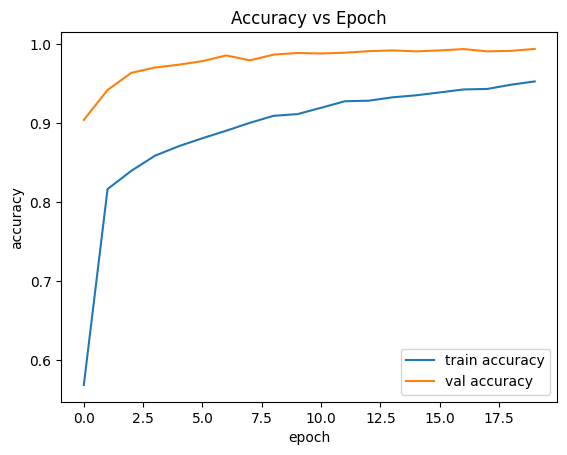

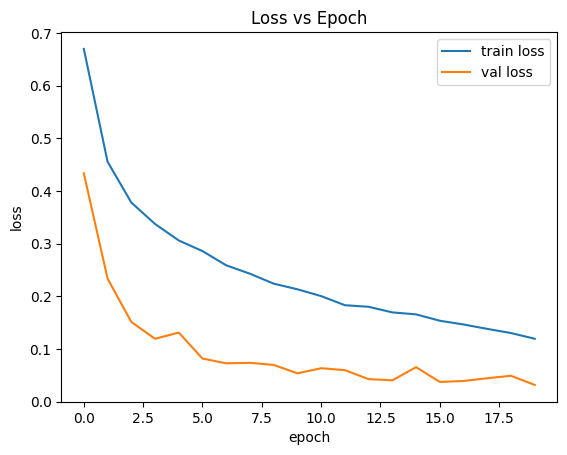

In [42]:
import matplotlib.pyplot as plt

# Accuracy
plt.figure()
plt.plot(history.history["accuracy"], label="train accuracy")
plt.plot(history.history["val_accuracy"], label="val accuracy")
plt.xlabel("epoch")
plt.ylabel("accuracy")
plt.legend()
plt.title("Accuracy vs Epoch")
plt.show()

# Loss
plt.figure()
plt.plot(history.history["loss"], label="train loss")
plt.plot(history.history["val_loss"], label="val loss")
plt.xlabel("epoch")
plt.ylabel("loss")
plt.legend()
plt.title("Loss vs Epoch")
plt.show()


In [43]:
def eval_at_threshold(y_prob, y_true, threshold=0.5):
    """
    y_prob: [N] probabilities
    y_true: [N] 0/1 labels
    """
    y_pred = (y_prob >= threshold).astype(int)
    y_true = y_true.astype(int)

    acc = (y_pred == y_true).mean()

    # False positive = predicted drone when it's not-drone
    fp = ((y_pred == 1) & (y_true == 0)).sum()
    tn = ((y_pred == 0) & (y_true == 0)).sum()
    fpr = fp / (fp + tn + 1e-12)

    # False negative = predicted not-drone when it's drone
    fn = ((y_pred == 0) & (y_true == 1)).sum()
    tp = ((y_pred == 1) & (y_true == 1)).sum()
    fnr = fn / (fn + tp + 1e-12)

    return acc, fpr, fnr


In [44]:
import numpy as np

def add_noise_at_snr(X, snr_db):
    """
    X: [N, F, T, 1] float32
    Returns noisy copy of X at approximately snr_db.
    """
    X = X.astype(np.float32)
    X_noisy = X.copy()

    snr_linear = 10 ** (snr_db / 10)

    # For each sample, compute signal power and add matching noise power
    for i in range(len(X_noisy)):
        sig_power = np.mean(X_noisy[i] ** 2) + 1e-12
        noise_power = sig_power / snr_linear
        noise = np.random.normal(
            0.0, np.sqrt(noise_power), size=X_noisy[i].shape
        ).astype(np.float32)
        X_noisy[i] = X_noisy[i] + noise

    return X_noisy


In [45]:
import matplotlib.pyplot as plt

# Make sure y_val is shape [N]
y_val_1d = y_val.reshape(-1)

snr_grid = [20, 10, 5, 0, -5, -10, -15, -20]
threshold = 0.5

results = []

for snr in snr_grid:
    X_test = add_noise_at_snr(X_val, snr_db=snr)

    # model.predict returns probabilities since your last layer is sigmoid
    y_prob = model.predict(X_test, verbose=0).flatten()

    acc, fpr, fnr = eval_at_threshold(y_prob, y_val_1d, threshold=threshold)
    results.append((snr, acc, fpr, fnr))

    print(f"SNR {snr:>4} dB | acc={acc:.3f} | FPR={fpr:.3f} | FNR={fnr:.3f}")


SNR   20 dB | acc=0.995 | FPR=0.002 | FNR=0.008
SNR   10 dB | acc=0.994 | FPR=0.004 | FNR=0.008
SNR    5 dB | acc=0.992 | FPR=0.006 | FNR=0.010
SNR    0 dB | acc=0.989 | FPR=0.010 | FNR=0.012
SNR   -5 dB | acc=0.975 | FPR=0.029 | FNR=0.021
SNR  -10 dB | acc=0.929 | FPR=0.063 | FNR=0.081
SNR  -15 dB | acc=0.812 | FPR=0.132 | FNR=0.248
SNR  -20 dB | acc=0.656 | FPR=0.214 | FNR=0.485


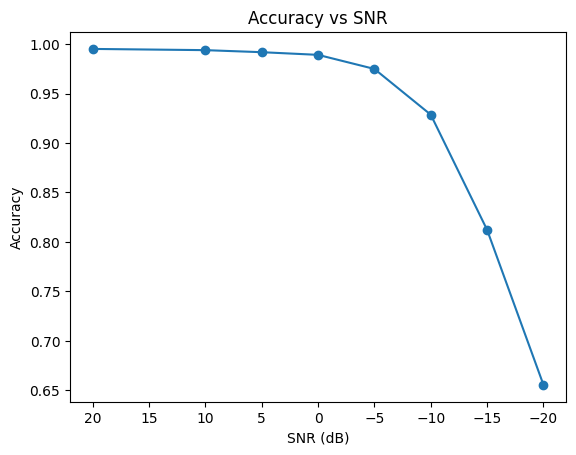

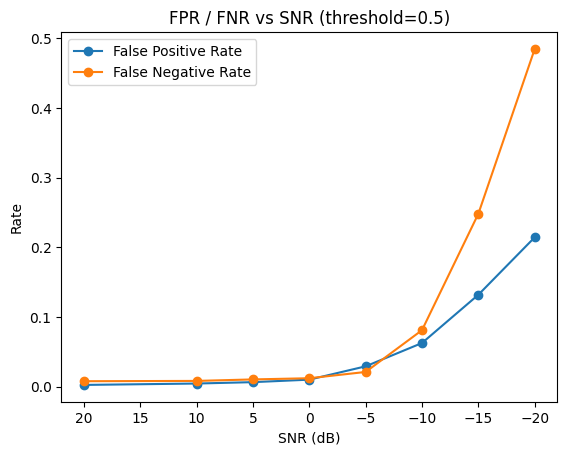

In [46]:
snrs = [r[0] for r in results]
accs = [r[1] for r in results]
fprs = [r[2] for r in results]
fnrs = [r[3] for r in results]

plt.figure()
plt.plot(snrs, accs, marker="o")
plt.gca().invert_xaxis()  # higher SNR on left, lower on right (nice visual)
plt.xlabel("SNR (dB)")
plt.ylabel("Accuracy")
plt.title("Accuracy vs SNR")
plt.show()

plt.figure()
plt.plot(snrs, fprs, marker="o", label="False Positive Rate")
plt.plot(snrs, fnrs, marker="o", label="False Negative Rate")
plt.gca().invert_xaxis()
plt.xlabel("SNR (dB)")
plt.ylabel("Rate")
plt.title("FPR / FNR vs SNR (threshold=0.5)")
plt.legend()
plt.show()
